<h1 style="font-size:50px; text-align:center">DCO Detections</h1>

In [11]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import legwork
import os
import sys
sys.path.append("../src/")
from variations import variations
from galaxy import simulate_mw

In [12]:
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [13]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
sim_folder = "../data/simulation_plus_channels/"

total_DCOs_in_MW = np.load("../data/total_DCO_in_MW.npy")
total_bound_DCOs_in_MW = np.load("../data/total_DCO_in_MW_nohubble.npy")

# Calculate number of detections

In [15]:
def get_detections(dco_type, MW_SIZE=100000, MW_MASS_FAC=1.5, t_obs=4*u.yr, only_frac=False):
    # set up arrays for return
    detections = np.zeros(shape=(len(dco_types), len(variations), 2500))
    
    # go through each physics variation
#     for d in range(len(dco_types)):
    
    for d in range(len(dco_types)):
        for v in range(len(variations)):
            # open the proper output file
            fname = sim_folder + "{}_{}_all.h5".format(dco_types[d], variations[v]["file"])
            if os.path.isfile(fname):
                with h5.File(fname, "r") as f:
                    n_ten_year = f["simulation"].attrs["n_ten_year"].astype(np.int)
                    full_data = f["simulation"][...].squeeze()

                # go through the file and normalise the detections for all binaries with SNR > x
                cursor = 0
                detections_per_MW = np.zeros(len(n_ten_year))
                for i in range(len(n_ten_year)):
                    snr = full_data["snr"][cursor:cursor + n_ten_year[i]]
                    weights = full_data["weights"][cursor:cursor + n_ten_year[i]]
                    detections[d][v][i] = np.sum(weights[snr * np.sqrt(t_obs / (4 * u.yr)) > 7]) / MW_SIZE
                    cursor += n_ten_year[i]
                if not only_frac:
                    detections[d][v] *= total_DCOs_in_MW[d][v] * MW_MASS_FAC

            # set to zero if no file exists (simulation will have crashed)
            else:
                detections[d][v] = 0
    
    return detections

In [16]:
detections_4yr = get_detections(dco_types)

In [ ]:
detections_10yr = get_detections(dco_types, t_obs=10*u.yr)

In [ ]:
detections_only_fractions = get_detections(dco_types, only_frac=True)

In [ ]:
np.save("../data/detections_4yr", detections_4yr)
np.save("../data/detections_10yr", detections_10yr)
np.save("../data/detections_only_fractions", detections_only_fractions)

# Plot number of detections

In [7]:
def plot_variations(dco_type, variations, detections,
                    dotsize=200, capwidth=0.1, error_bars=[(1, "-"), (2, "dotted")],
                    xlabel="Model Variation", ylabel="LISA Detections", shadow=False,
                    yscale="log", fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))
    
    # work out mean and standard deviations
    means = detections.mean(axis=2)[dco_types.index(dco_type)]
    stds = detections.std(axis=2)[dco_types.index(dco_type)]
    
    # plot the means as points
    xticks = range(len(variations))
    colours = np.array([variations[v]["colour"] for v in range(len(variations))], dtype="object")
    ax.scatter(xticks, means, s=dotsize, color=colours, zorder=5)
    
    # for each variation and error bar
    for v in range(len(variations)):
        for sigma, style in error_bars:
            # plot line up to error (adjust width and style)
            ax.plot([xticks[v], xticks[v]],
                    [means[v] - stds[v] * sigma, means[v] + stds[v] * sigma],
                    color=colours[v], linewidth=4 / sigma, linestyle=style)

            # plot caps on top of error bars
            for sign in [-1, 1]:
                ax.plot([xticks[v] - capwidth, xticks[v] + capwidth],
                        [means[v] + sign * stds[v] * sigma, means[v] + sign * stds[v] * sigma],
                        color=colours[v], linewidth=4 / sigma, linestyle=style)

    ax.set_xticks(xticks)
    ax.set_xticklabels([variations[v]["short"] for v in range(len(variations))])
    
    ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5)
    
    ax.set_yscale(yscale)
    
    xlims = ax.get_xlim()
    
    if shadow:
        ax.fill_between(xlims, means[0] - stds[0], means[0] + stds[0], color="grey", alpha=0.1, zorder=-1)
        ax.fill_between(xlims, means[0] - 2* stds[0], means[0] + 2 * stds[0], color="grey", alpha=0.1, zorder=-1)

    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fs)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fs)

    ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)

    ax.annotate(dco_type, xy=(0.015, 0.04), xycoords="axes fraction", fontsize=fs,
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.0))

    ax.grid(axis="y", which="major", lw=1.5, linestyle="--")
    ax.grid(axis="y", which="minor", lw=0.3)
    
    if show:
        plt.show()
    return fig, ax

## Overall detection rate

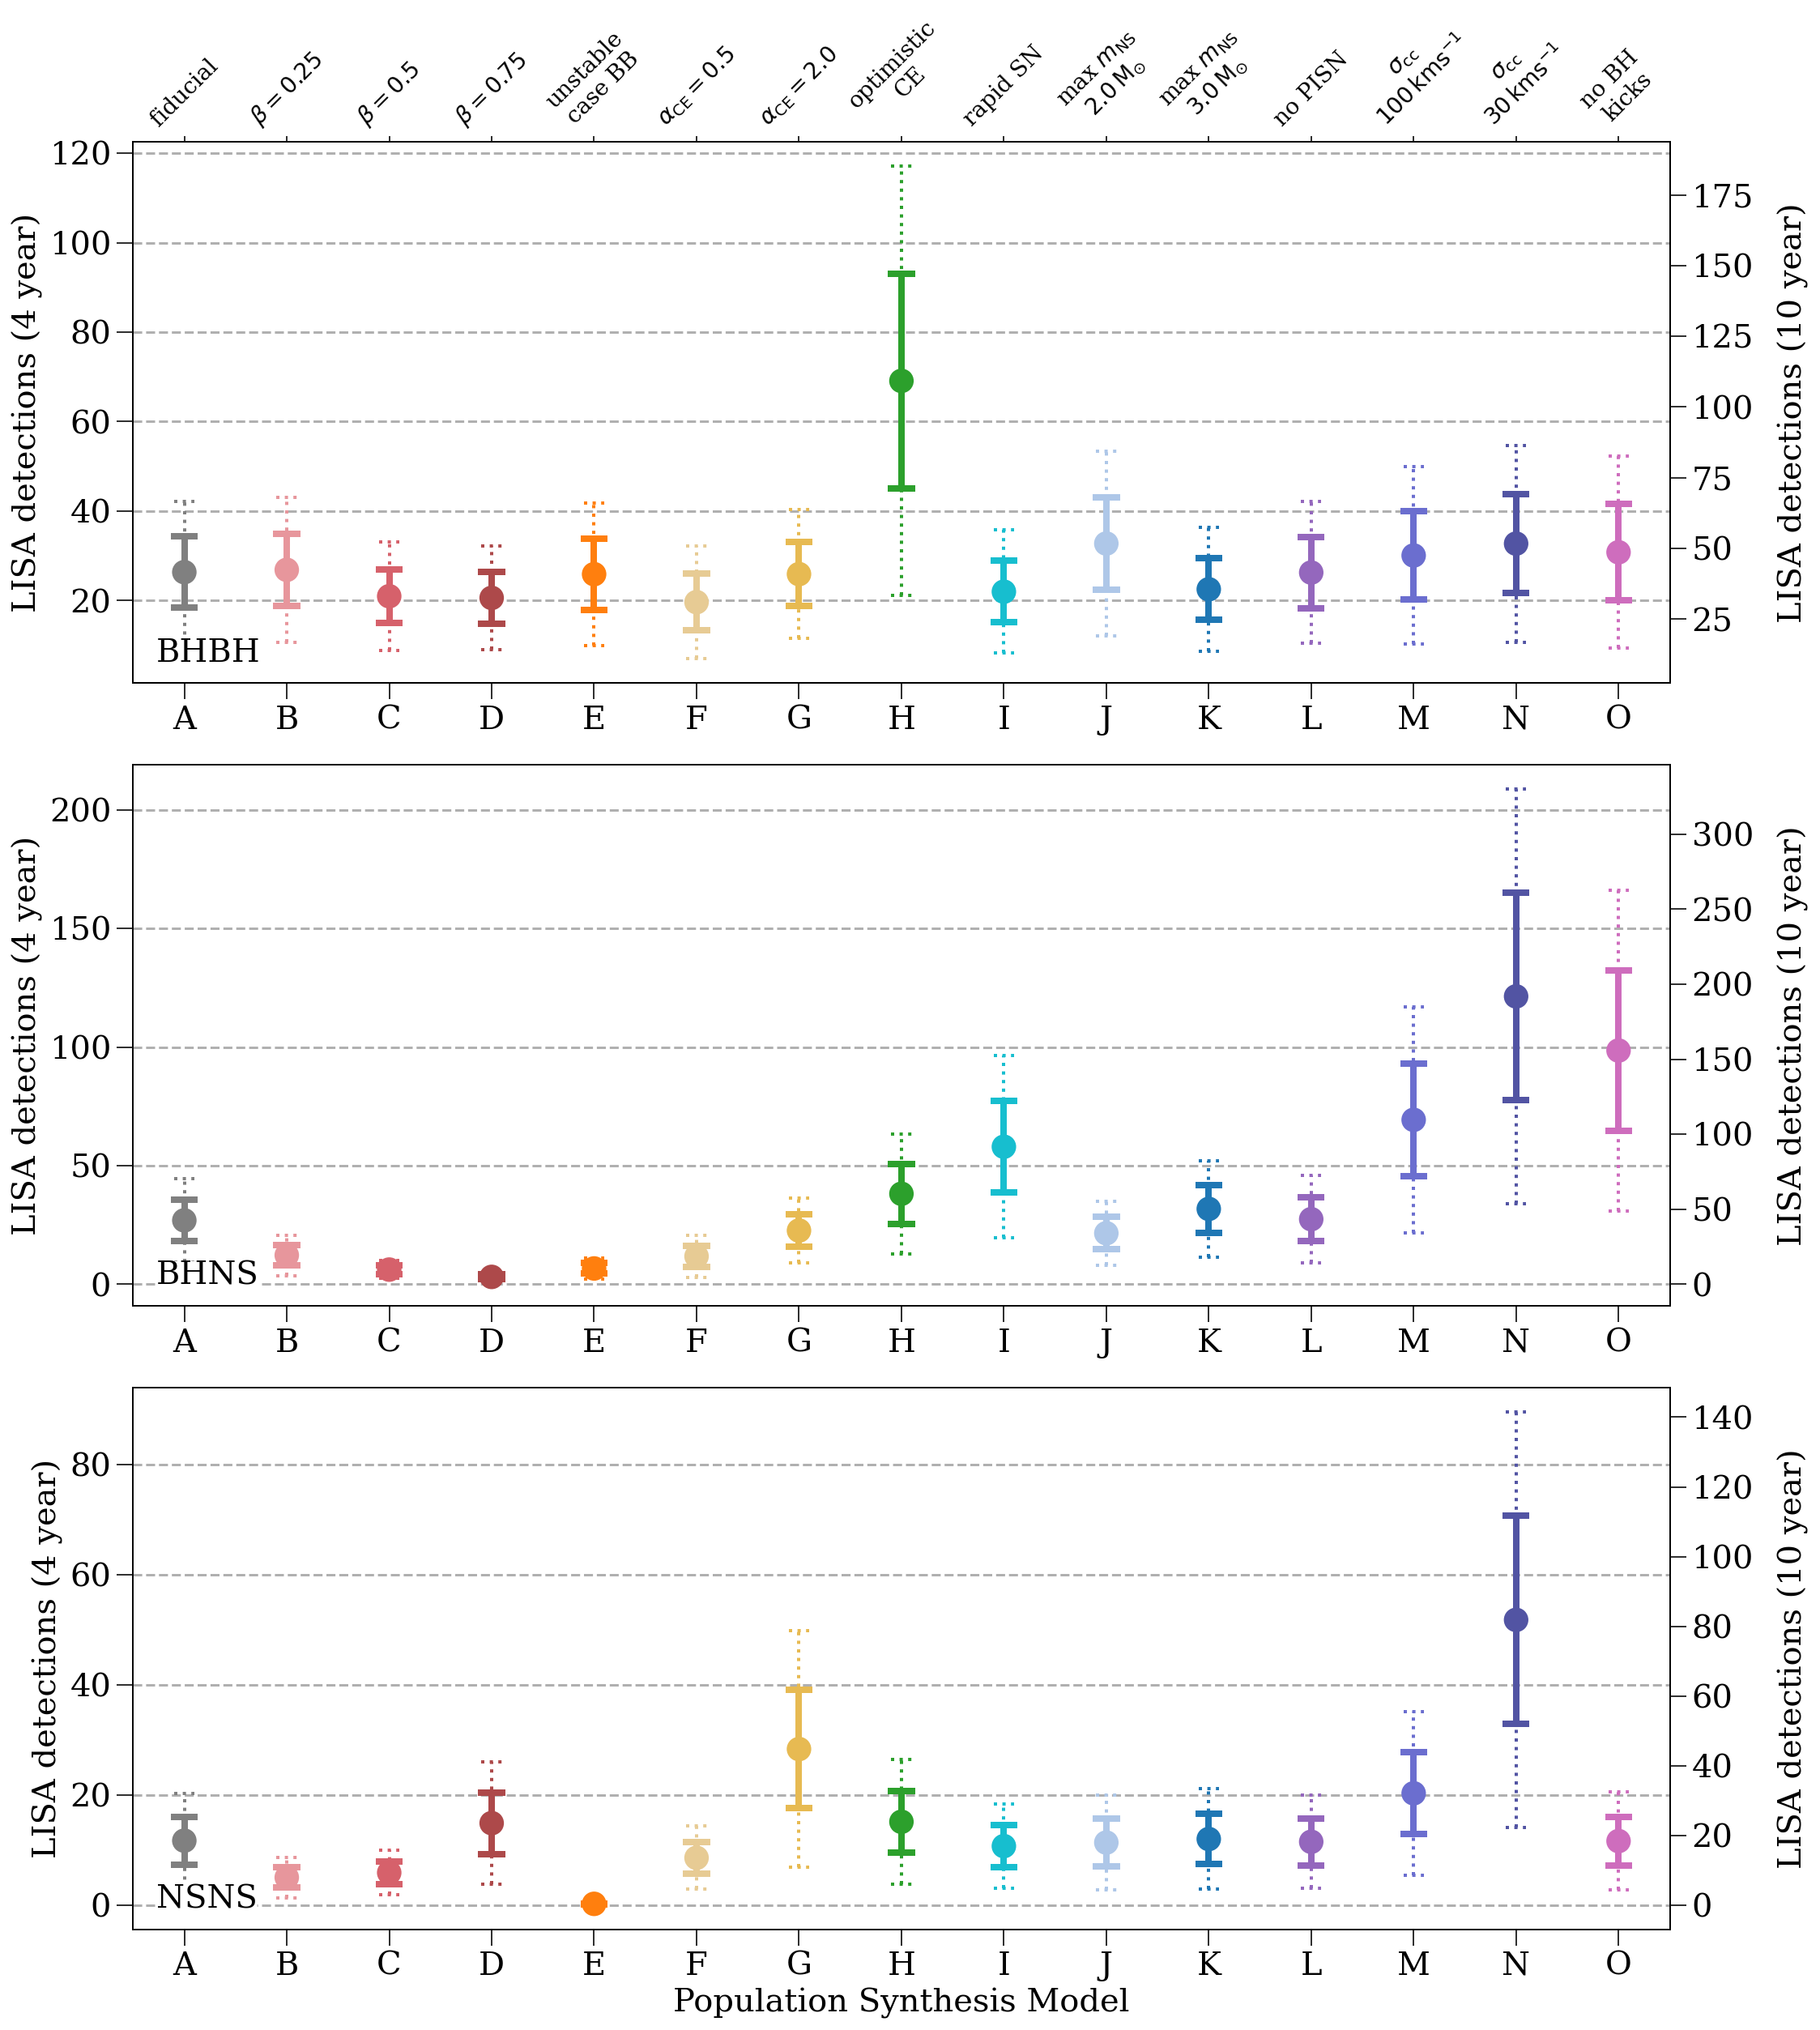

In [23]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

for ax, dco_type, col in zip(axes, dco_types, colours):
    plot_variations(dco_type, variations, detections_4yr,
                    xlabel=None, ylabel="LISA detections (4 year)",
                    fig=fig, ax=ax, show=False, yscale="linear")
    
    right_ax = ax.twinx()
    right_ax.set_ylim(tuple(np.array(ax.get_ylim()) * np.sqrt(10 / 4)))
#     right_ax.set_yscale("log")
    right_ax.set_ylabel("LISA detections (10 year)", labelpad=15)
    right_ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    right_ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)
    
top_ax = axes[0].twiny()
top_ax.set_xticks(axes[0].get_xticks())
top_ax.set_xlim(axes[0].get_xlim())
top_ax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)

# plt.savefig("../../paper/figures/dco_detections.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

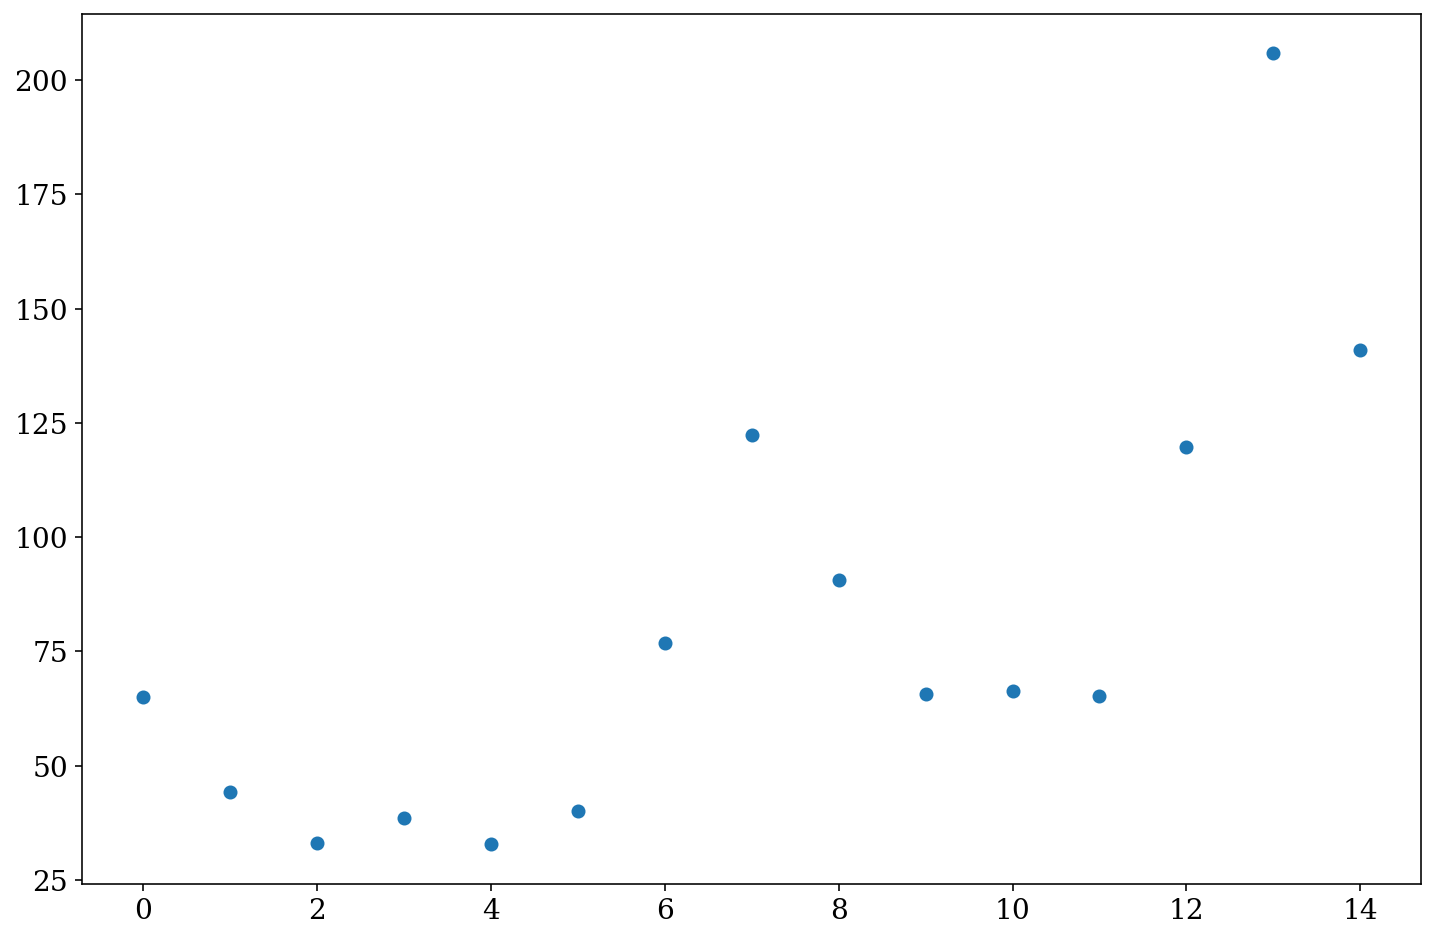

In [26]:
plt.scatter(range(15), detections_4yr.sum(axis=0).mean(axis=1))
plt.show()

## Detectable fraction

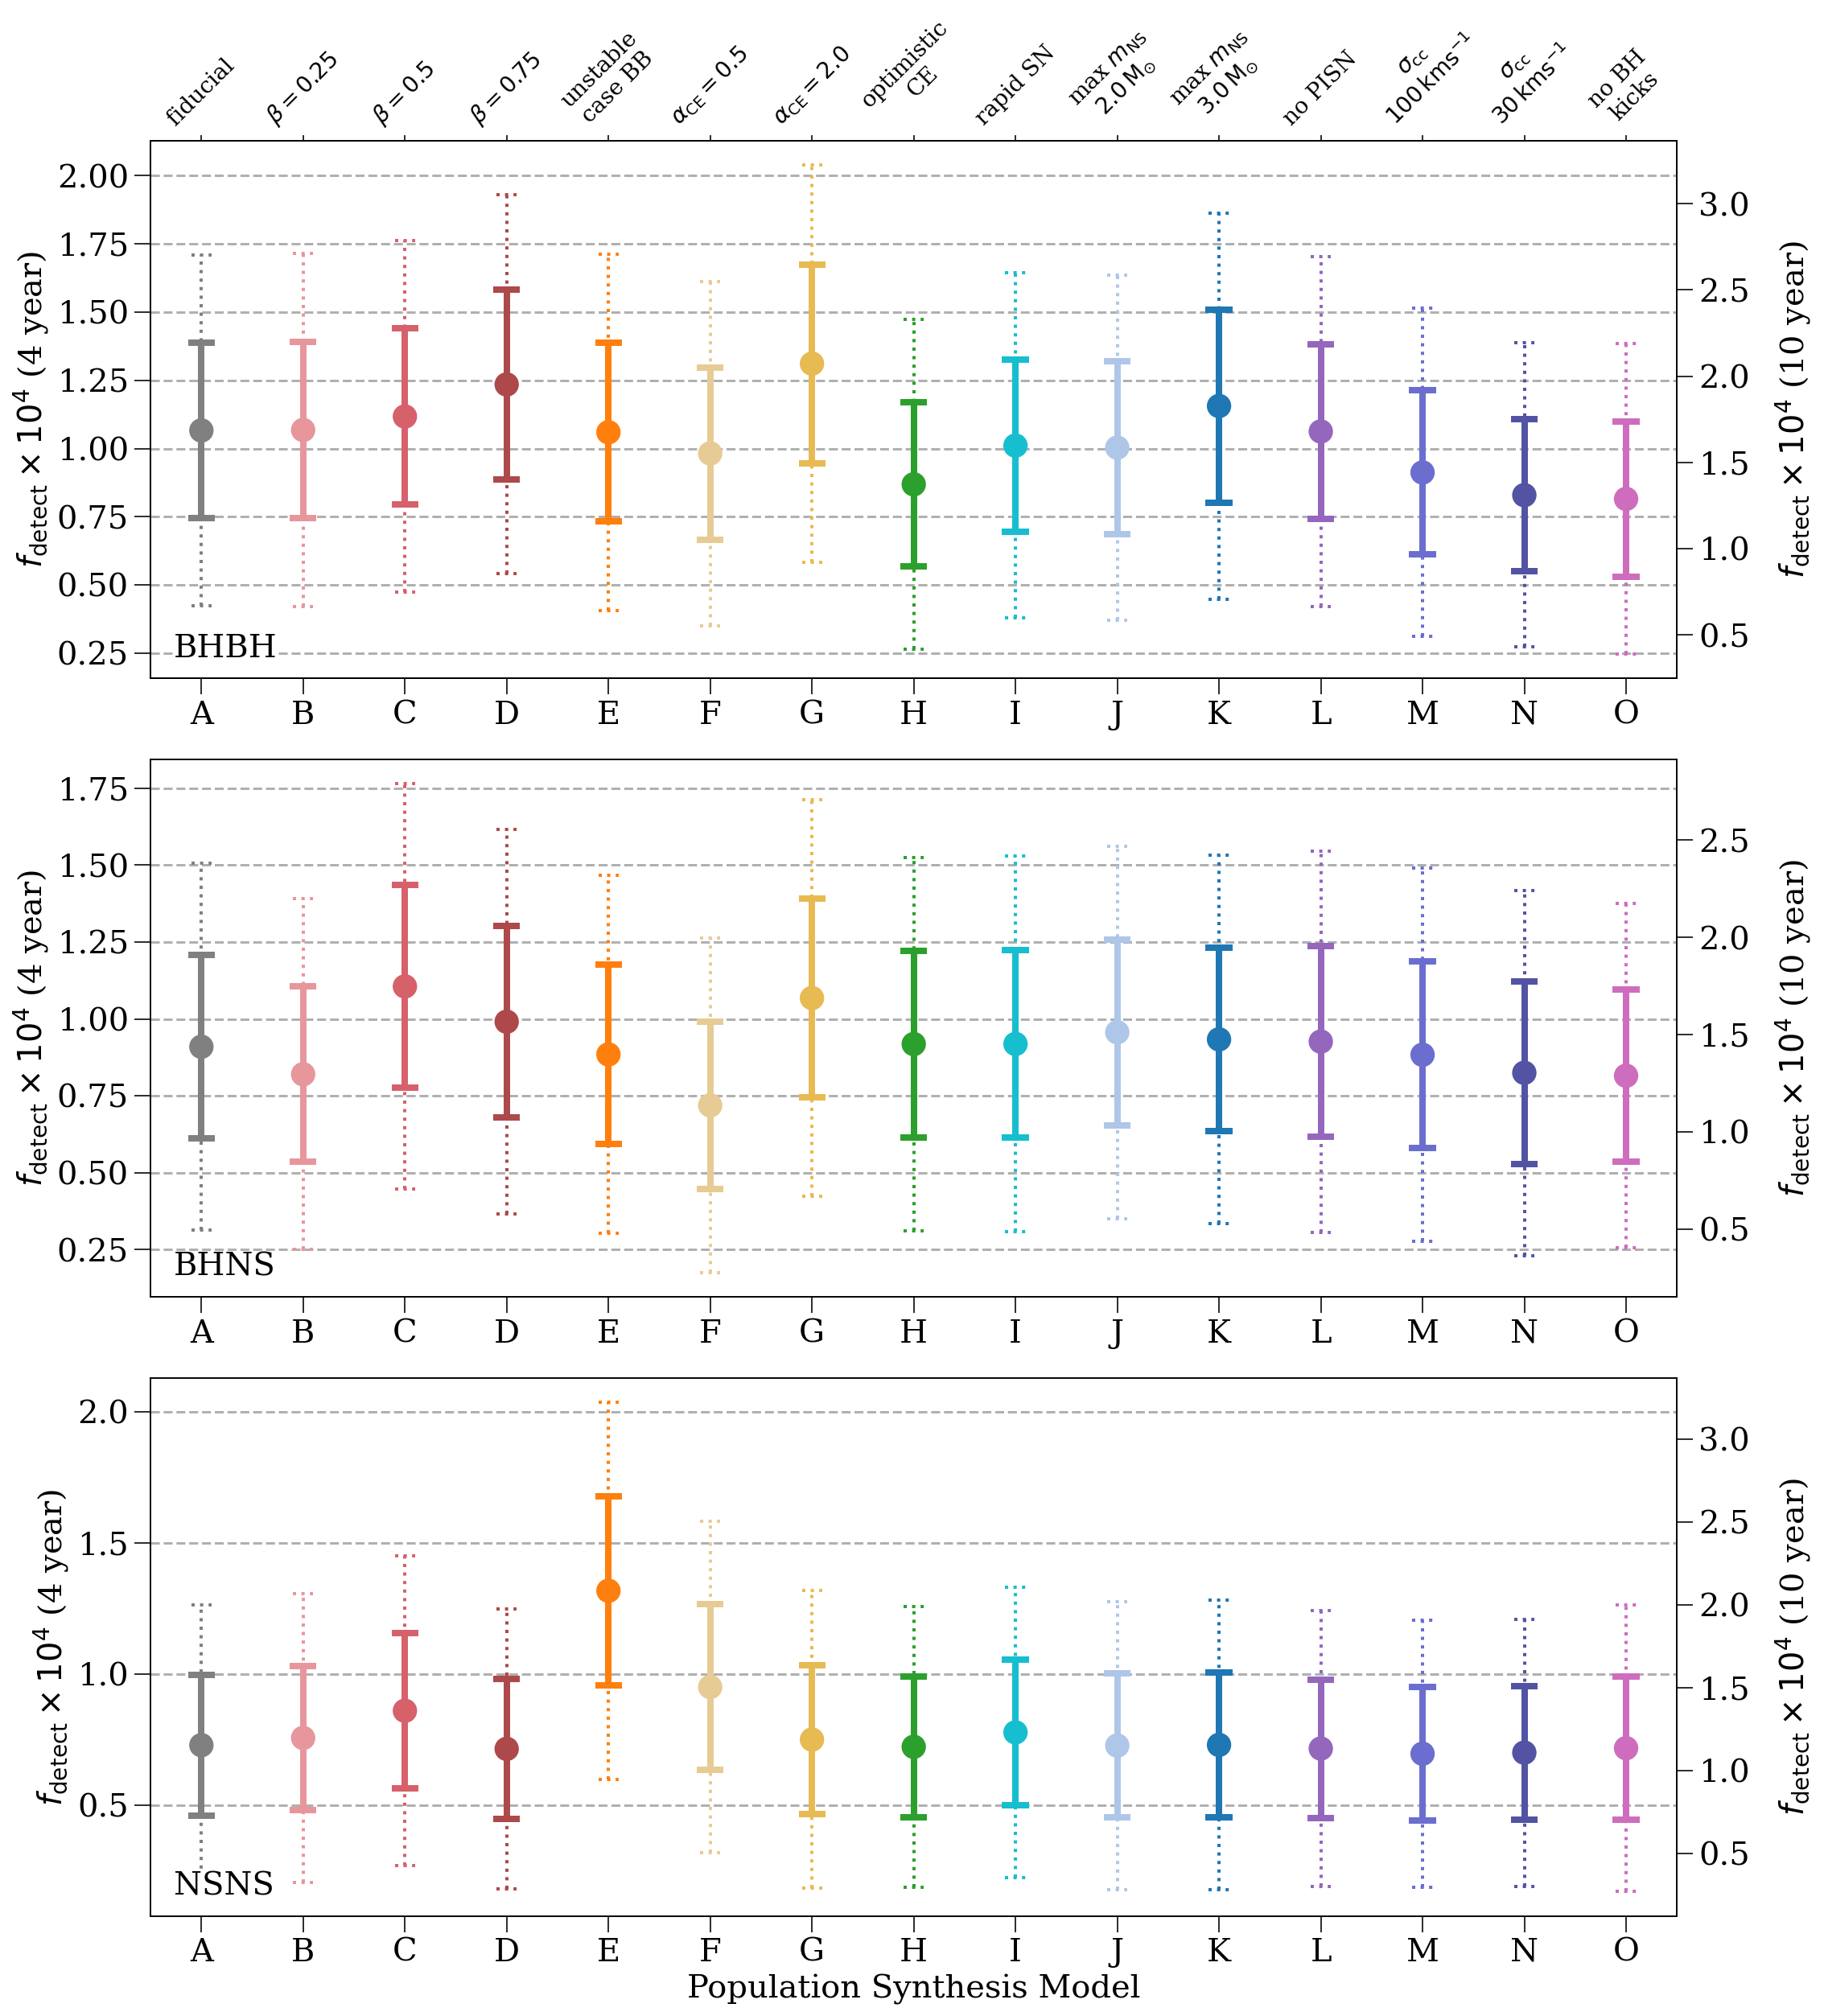

In [113]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

for ax, dco_type, col in zip(axes, dco_types, colours):
    plot_variations(dco_type, variations, detections_only_fractions * 1e4,
                    xlabel=None, ylabel=r"$f_{\rm detect} \times 10^{4}$ (4 year)",
                    yscale="linear", fig=fig, ax=ax, show=False)
    
    right_ax = ax.twinx()
    right_ax.set_ylim(tuple(np.array(ax.get_ylim()) * np.sqrt(10 / 4)))
    right_ax.set_yscale("linear")
    right_ax.set_ylabel(r"$f_{\rm detect} \times 10^{4}$ (10 year)", labelpad=15)
    right_ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    right_ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)
    
top_ax = axes[0].twiny()
top_ax.set_xticks(axes[0].get_xticks())
top_ax.set_xlim(axes[0].get_xlim())
top_ax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)

plt.savefig("../../paper/figures/dco_detections_fractions.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

## Total bound DCOs

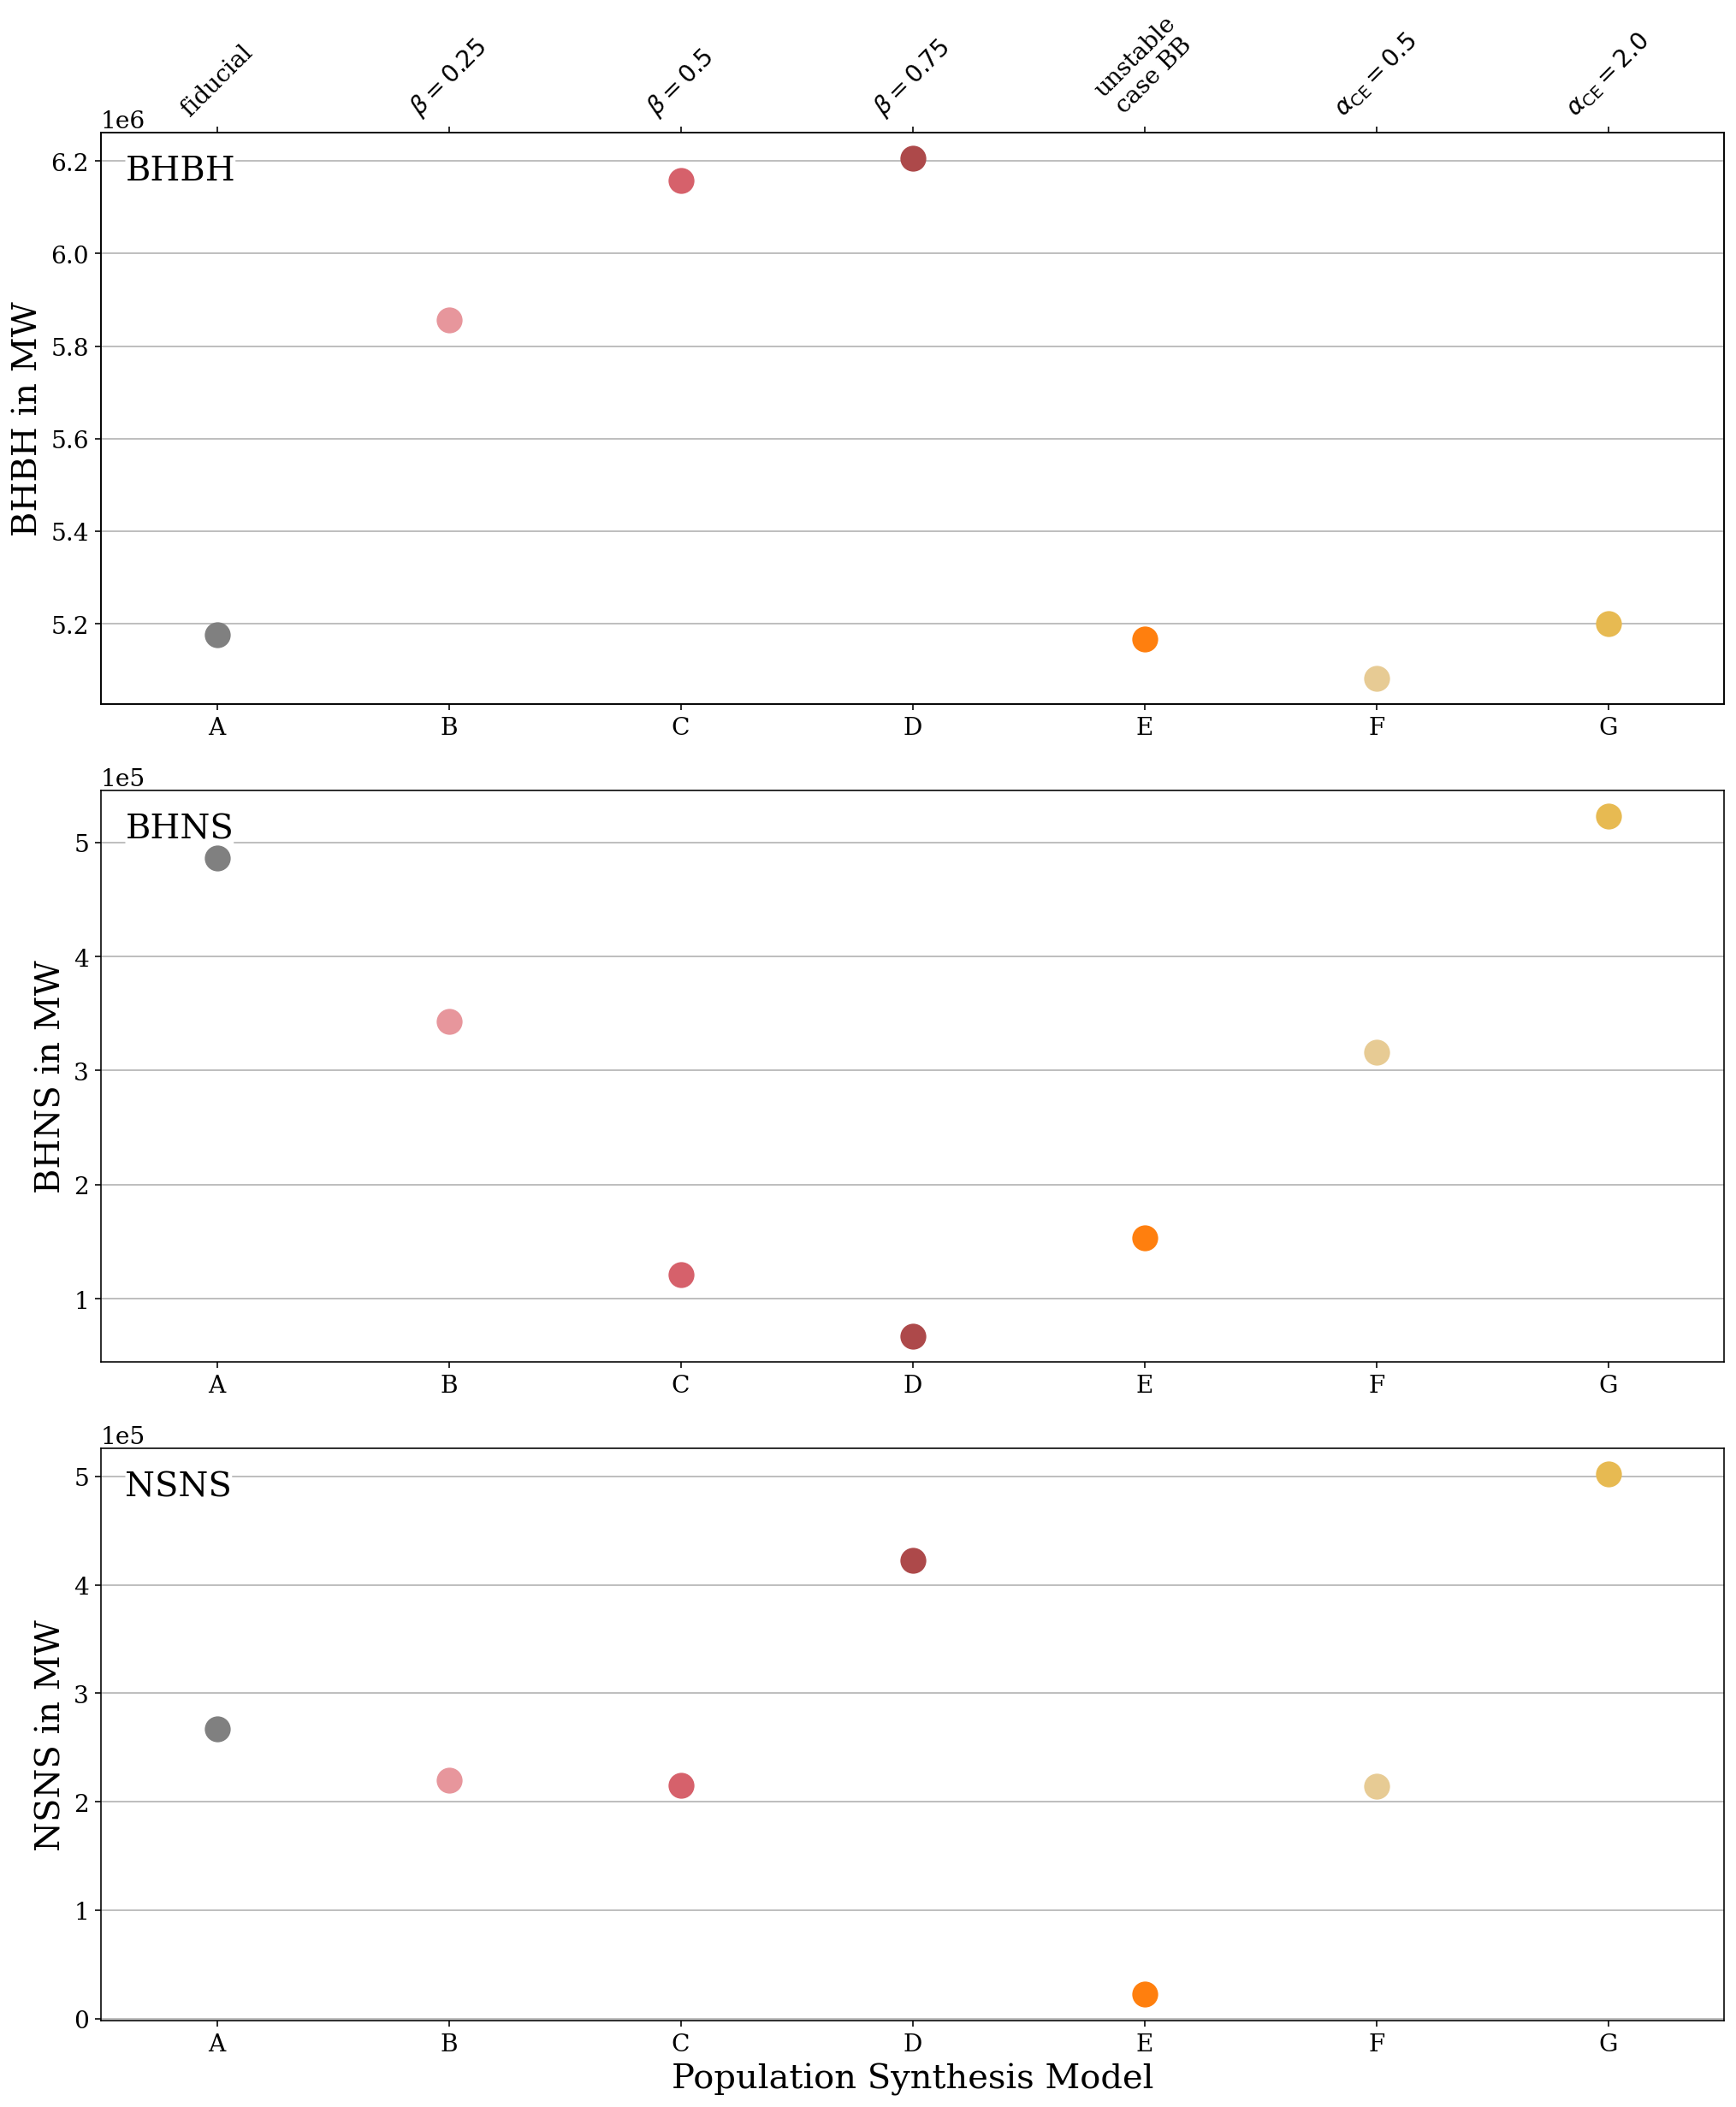

In [8]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

which_variations = [0, 1, 2, 3, 4, 5, 6]

for i in range(len(axes)):
    colours = np.array([variations[v]["colour"] for v in which_variations], dtype="object")
    
    for v in which_variations:
        axes[i].scatter(v, total_bound_DCOs_in_MW[i][v] * 1.5, color=variations[v]["colour"], s=200, zorder=10)
    
    ax = axes[i]
    
    ax.set_xticks(which_variations)
    ax.set_xticklabels([variations[v]["short"] for v in which_variations])
    ax.annotate(dco_types[i], xy=(0.015, 1 - 0.04), xycoords="axes fraction", fontsize=fs, va="top",
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.0))

    ax.set_xlim(which_variations[0] - 0.5, which_variations[-1] + 0.5)
    ax.set_ylabel("{} in MW".format(dco_types[i]))
    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    ax.grid(axis="y", which="major")
    
topax = axes[0].twiny()
topax.set_xticks(axes[0].get_xticks())
topax.set_xlim(axes[0].get_xlim())
topax.set_xticklabels([variations[v]["med"] for v in which_variations], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)
    
plt.show()

## Total DCOs merging in Hubble time

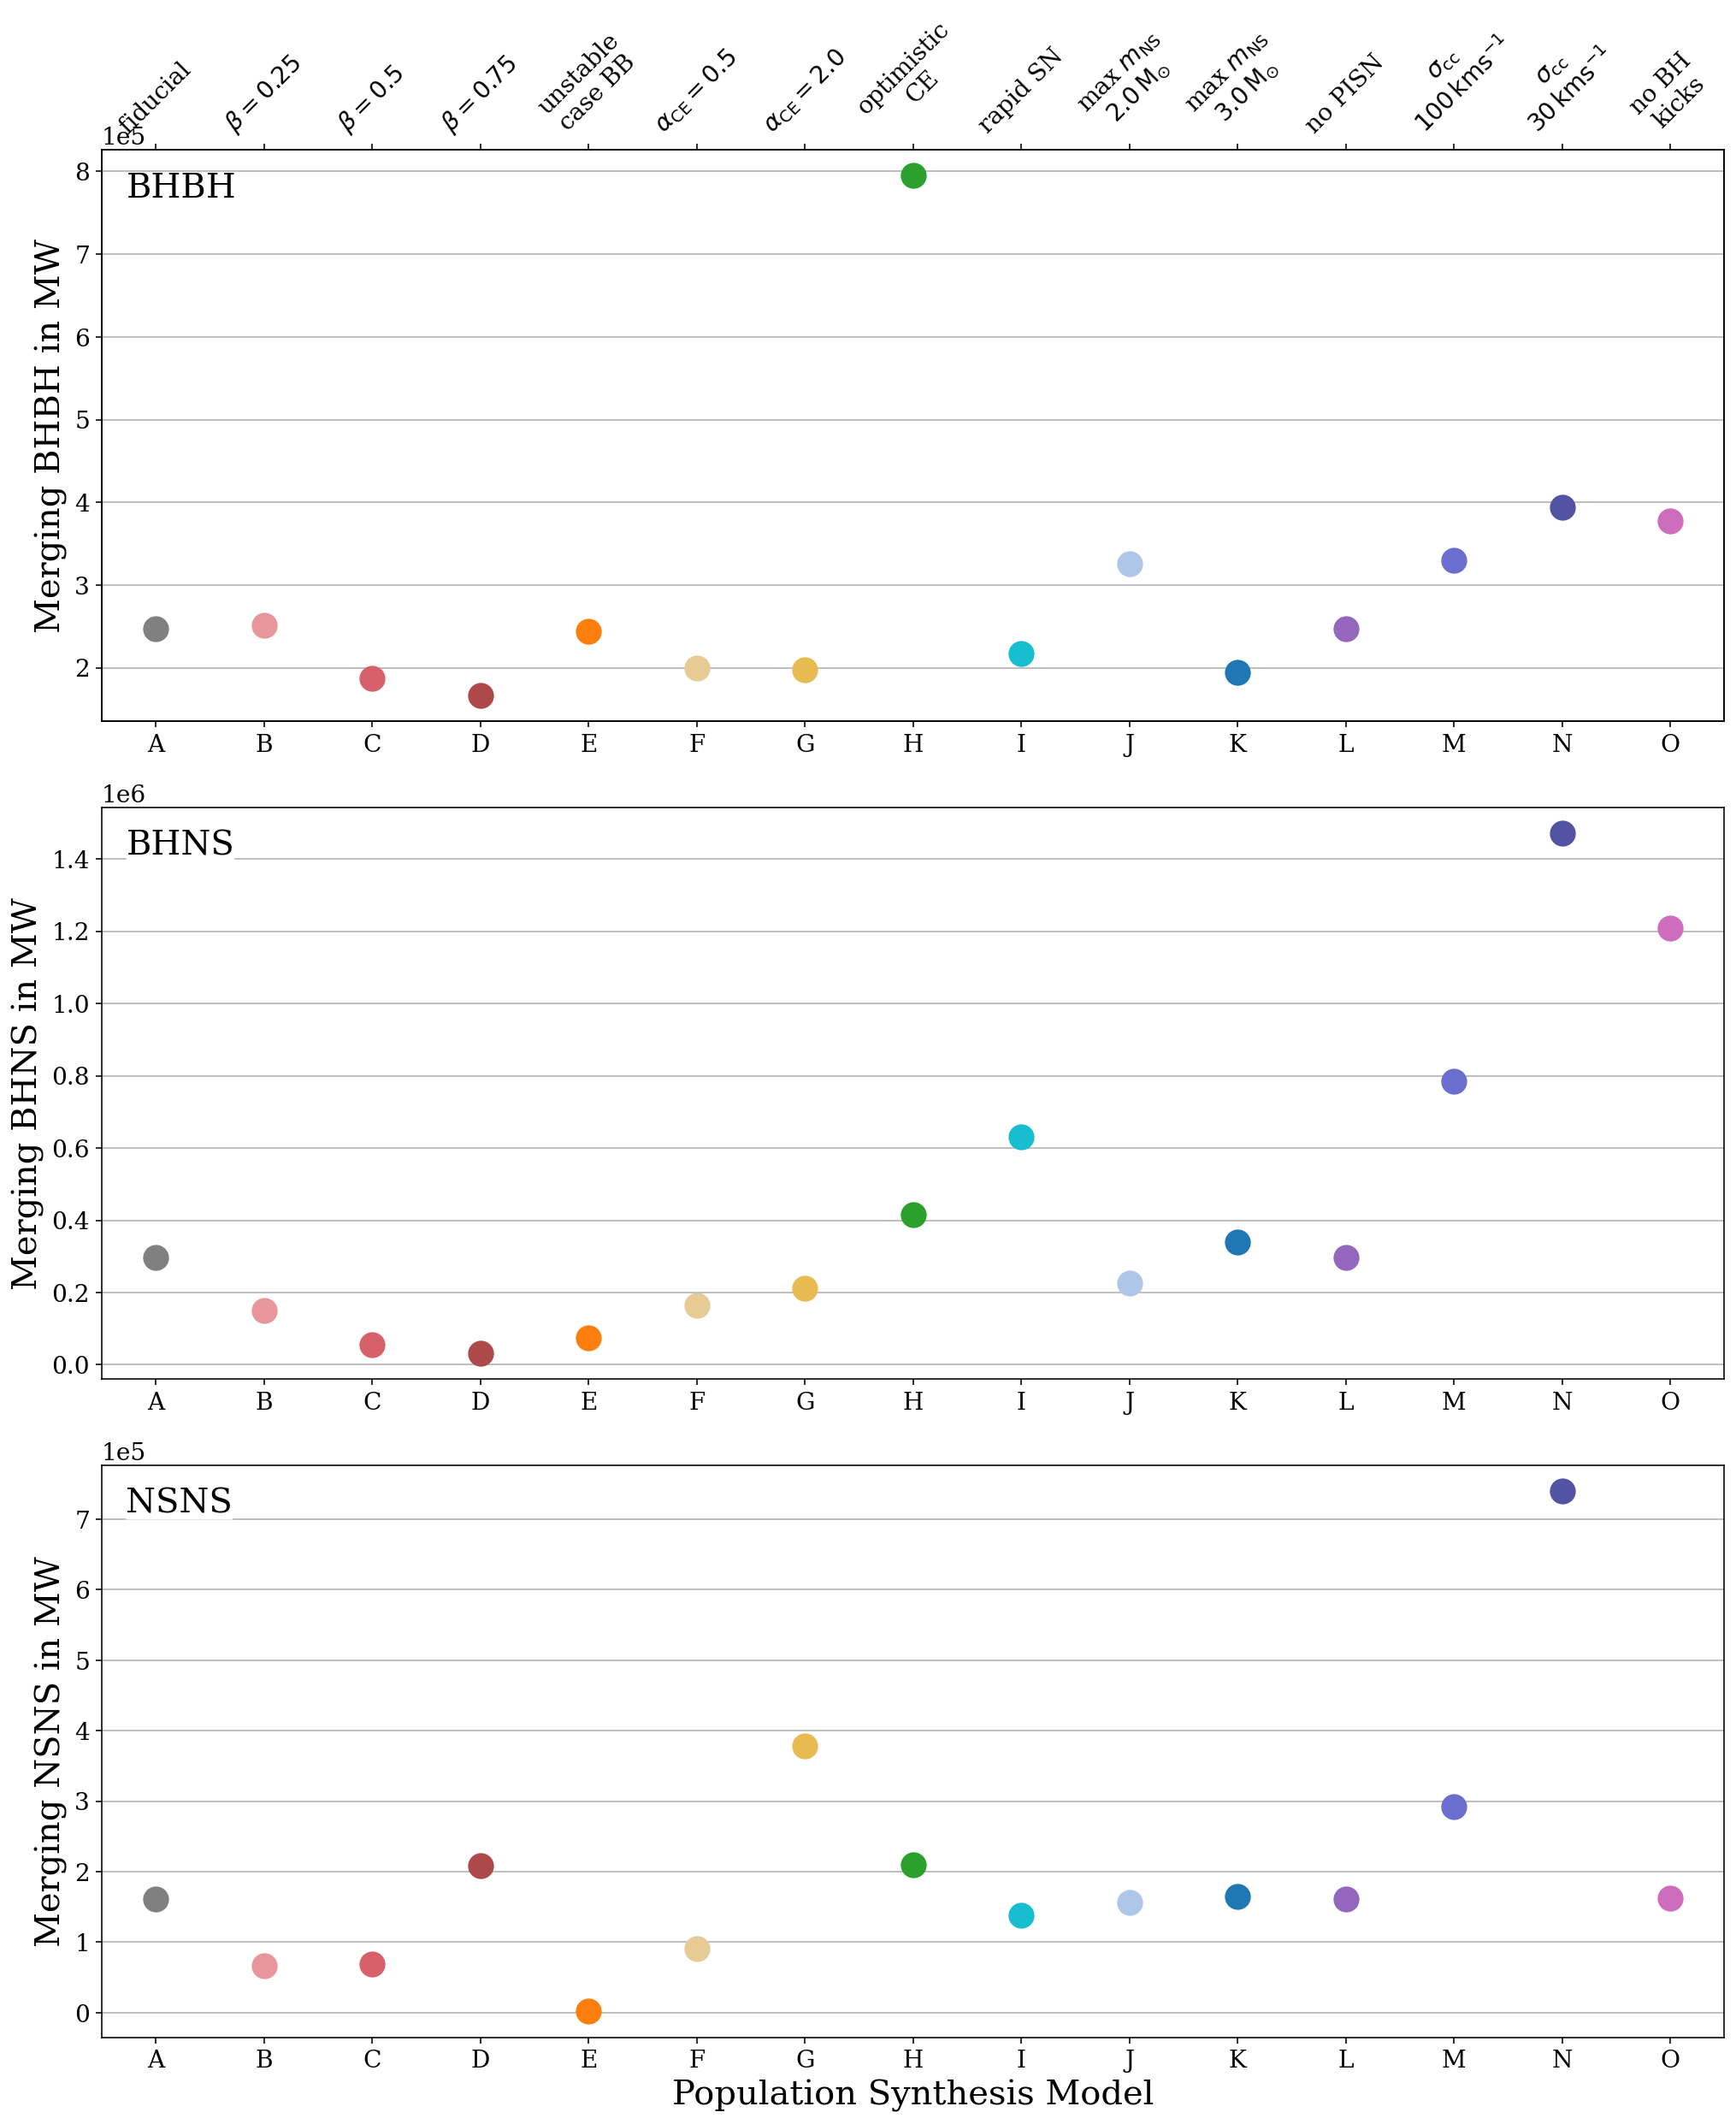

In [17]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

for i in range(len(axes)):
    xticks = range(len(variations))
    colours = np.array([variations[v]["colour"] for v in range(len(variations))], dtype="object")
    
    for j in range(len(xticks)):
        axes[i].scatter(xticks[j], total_DCOs_in_MW[i][j] * 1.5, color=colours[j], s=200, zorder=10)
    
    ax = axes[i]
    
    ax.set_xticks(xticks)
    ax.set_xticklabels([variations[v]["short"] for v in range(len(variations))])
    ax.annotate(dco_types[i], xy=(0.015, 1 - 0.04), xycoords="axes fraction", fontsize=fs, va="top",
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.0))

    ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5)
    ax.set_ylabel("Merging {} in MW".format(dco_types[i]))
    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    ax.grid(axis="y", which="major")
    
topax = axes[0].twiny()
topax.set_xticks(axes[0].get_xticks())
topax.set_xlim(axes[0].get_xlim())
topax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)

plt.savefig("../../paper/figures/dco_merging.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

# Table

In [126]:
for i in range(len(variations)):
    table_line = variations[i]["short"]
    for detection in [detections, detections10yr]:
        for j in range(len(detection)):
            median = np.median(detection[j][i])
            five, ninefive = np.percentile(detection[j][i], [5, 95])
            lower = median - five
            upper = ninefive - median
            table_line += r" & \confinv{" + "{:.1f}".format(median) + "}{" \
                        + "{:.1f}".format(lower) + "}{" \
                        + "{:.1f}".format(upper) + "}"
    table_line += "\\\\"
    print(table_line)

A & \confinv{25.9}{11.1}{13.6} & \confinv{26.7}{11.9}{14.8} & \confinv{11.3}{6.4}{8.0} & \confinv{42.0}{17.3}{17.3} & \confinv{44.5}{17.8}{20.7} & \confinv{19.3}{8.0}{9.7}\\
B & \confinv{27.7}{12.6}{12.6} & \confinv{12.0}{6.0}{7.5} & \confinv{4.7}{2.7}{3.3} & \confinv{42.7}{17.6}{17.6} & \confinv{19.5}{7.5}{10.5} & \confinv{8.0}{3.3}{4.0}\\
C & \confinv{20.6}{9.4}{11.3} & \confinv{6.2}{2.8}{3.4} & \confinv{5.5}{2.7}{4.1} & \confinv{33.8}{13.1}{13.1} & \confinv{10.1}{3.9}{3.9} & \confinv{9.6}{4.1}{4.1}\\
D & \confinv{20.0}{8.3}{10.0} & \confinv{3.2}{1.6}{1.6} & \confinv{14.6}{8.3}{10.4} & \confinv{31.7}{11.7}{11.7} & \confinv{5.1}{1.9}{2.2} & \confinv{22.9}{10.4}{12.5}\\
E & \confinv{24.4}{12.2}{14.7} & \confinv{6.8}{3.8}{3.8} & \confinv{0.2}{0.1}{0.1} & \confinv{41.5}{17.1}{17.1} & \confinv{10.6}{3.8}{5.3} & \confinv{0.4}{0.1}{0.2}\\
F & \confinv{20.0}{10.0}{10.0} & \confinv{11.5}{6.6}{8.2} & \confinv{8.1}{3.6}{5.4} & \confinv{30.0}{12.0}{14.0} & \confinv{19.7}{9.9}{9.9} & \confinv{13.